In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

In [13]:
df=pd.read_csv('credit_scoring.csv')

### Data Descriptions

| Variable Name                  | Description                                                                 | Type       |
|:-------------------------------|:----------------------------------------------------------------------------|:-----------|
| Default                        | Client with more than 90 days without paying their loan                     | Y/N        |
| Prct_uso_tc                    | Percentage of credit card usage in the last month                           | percentage |
| Edad                           | Age                                                                         | integer    |
| Nro_prestamo_retrasados        | Number of loans with payment delays of more than 3 months in the last 3 years | integer    |
| Prct_deuda_vs_ingresos         | Financial debt-to-income ratio                                              | percentage |
| Mto_ingreso_mensual            | Monthly income amount                                                       | real       |
| Nro_prod_financieros_deuda     | Number of loans (including vehicle or mortgage loans) and number of credit cards last year | integer |
| Nro_retraso_60dias             | Number of times the client has been over 60 days late in the last 3 years    | integer    |
| Nro_creditos_hipotecarios      | Number of mortgage loans                                                    | integer    |
| Nro_retraso_ultm3anios         | Number of payment delays over 30 days in the last 3 years                   | integer    |
| Nro_dependiente                | Number of dependents                                                        | integer    |


In [14]:
df.head(5)

,ID,Default,Prct_uso_tc,Edad,Nro_prestao_retrasados,Prct_deuda_vs_ingresos,Mto_ingreso_mensual,Nro_prod_financieros_deuda,Nro_retraso_60dias,Nro_creditos_hipotecarios,Nro_retraso_ultm3anios,Nro_dependiente
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [15]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 ID                                0
Default                           0
Prct_uso_tc                       0
Edad                              0
Nro_prestao_retrasados            0
Prct_deuda_vs_ingresos            0
Mto_ingreso_mensual           29731
Nro_prod_financieros_deuda        0
Nro_retraso_60dias                0
Nro_creditos_hipotecarios         0
Nro_retraso_ultm3anios            0
Nro_dependiente                3924
dtype: int64


In [16]:
# Handling missing values in 'Mto_ingreso_mensual'
# Option 1: Replace with median
# df['Mto_ingreso_mensual'].fillna(df['Mto_ingreso_mensual'].median(), inplace=True)

# Option 2: Predictive imputation (if preferred)
# Uncomment and use this block for predictive imputation

# Separate rows with and without missing target values
impute_df = df[df['Mto_ingreso_mensual'].notnull()]
predict_df = df[df['Mto_ingreso_mensual'].isnull()]

# Define predictors (drop columns not used for prediction)
X_train = impute_df.drop(['Mto_ingreso_mensual', 'ID', 'Default'], axis=1)
y_train = impute_df['Mto_ingreso_mensual']
X_predict = predict_df.drop(['Mto_ingreso_mensual', 'ID', 'Default'], axis=1)

# Impute missing values in predictors
imputer = SimpleImputer(strategy='mean')  # You can use 'median' or 'most_frequent' instead
X_train = imputer.fit_transform(X_train)
X_predict = imputer.transform(X_predict)

# Train the regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict missing values
predicted_values = reg.predict(X_predict)

# Fill missing values in the original DataFrame
df.loc[df['Mto_ingreso_mensual'].isnull(), 'Mto_ingreso_mensual'] = predicted_values

# Handling missing values in 'Nro_dependiente'
# Replace missing values with median
df['Nro_dependiente'].fillna(df['Nro_dependiente'].median(), inplace=True)

# Verify there are no missing values left
print("Missing Values After Imputation:\n", df.isnull().sum())

Missing Values After Imputation:
 ID                            0
Default                       0
Prct_uso_tc                   0
Edad                          0
Nro_prestao_retrasados        0
Prct_deuda_vs_ingresos        0
Mto_ingreso_mensual           0
Nro_prod_financieros_deuda    0
Nro_retraso_60dias            0
Nro_creditos_hipotecarios     0
Nro_retraso_ultm3anios        0
Nro_dependiente               0
dtype: int64


In [100]:
df.columns

Index(['ID', 'Default', 'Prct_uso_tc', 'Edad', 'Nro_prestao_retrasados',
       'Prct_deuda_vs_ingresos', 'Mto_ingreso_mensual',
       'Nro_prod_financieros_deuda', 'Nro_retraso_60dias',
       'Nro_creditos_hipotecarios', 'Nro_retraso_ultm3anios',
       'Nro_dependiente'],
      dtype='object')

In [18]:
# df.rename(columns={
#     'Prct_uso_tc': 'per_credit_card_usage',
#     'Edad': 'age',
#     'Nro_prestao_retrasados': 'No_loans_3mts_3yrs',
#     'Prct_deuda_vs_ingresos': 'debt_to_income',
#     'Mto_ingreso_mensual': 'monthly_income',
#     'Nro_prod_financieros_deuda': 'number_loans_and_credit_cards',
#     'Nro_retraso_60dias':'60days_late_3yrs',
#     'Nro_creditos_hipotecarios':'mortgage_loans',
#     'Nro_retraso_ultm3anios':'pay_delays_30ds_3yrs',
#     'Nro_dependiente':'number_dependent'
# }, inplace=True)

In [19]:
# df[['Default','age','debt_to_income']]

In [21]:
df = df[df['ID'] != 65696]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          149999 non-null  int64  
 1   Default                     149999 non-null  int64  
 2   Prct_uso_tc                 149999 non-null  float64
 3   Edad                        149999 non-null  int64  
 4   Nro_prestao_retrasados      149999 non-null  int64  
 5   Prct_deuda_vs_ingresos      149999 non-null  float64
 6   Mto_ingreso_mensual         149999 non-null  float64
 7   Nro_prod_financieros_deuda  149999 non-null  int64  
 8   Nro_retraso_60dias          149999 non-null  int64  
 9   Nro_creditos_hipotecarios   149999 non-null  int64  
 10  Nro_retraso_ultm3anios      149999 non-null  int64  
 11  Nro_dependiente             149999 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 14.9 MB


In [23]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 ID                            0
Default                       0
Prct_uso_tc                   0
Edad                          0
Nro_prestao_retrasados        0
Prct_deuda_vs_ingresos        0
Mto_ingreso_mensual           0
Nro_prod_financieros_deuda    0
Nro_retraso_60dias            0
Nro_creditos_hipotecarios     0
Nro_retraso_ultm3anios        0
Nro_dependiente               0
dtype: int64


### Classifications

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer

In [26]:
# Selecting the identified features and the target variable
selected_features = ['Prct_deuda_vs_ingresos', 'Mto_ingreso_mensual', 'Edad', 
                     'Nro_prestao_retrasados', 'Nro_dependiente', 'Prct_uso_tc']
target = 'Default'

# Handling missing values with imputation
imputer = SimpleImputer(strategy='mean')
df[selected_features] = imputer.fit_transform(df[selected_features])

# Splitting into features (X) and target variable (y)
X = df[selected_features]
y = df[target]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Decision Tree Classifier

In [95]:
# Initialize and train the model
clf = DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=42)
clf=clf.fit(X_train, y_train)

# Make predictions
y_pred_dt = clf.predict(X_test)

# Evaluate the model
print("----- Decision Tree -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

----- Decision Tree -----
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.68      0.80     28041
           1       0.15      0.81      0.25      1959

    accuracy                           0.68     30000
   macro avg       0.56      0.74      0.53     30000
weighted avg       0.93      0.68      0.76     30000



In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example ground truth and predictions (replace with your actual data)
y_true = y_test  # True labels
y_pred = y_pred_dt  # Predicted labels

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Sensitivity / Recall (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Precision
precision = precision_score(y_true, y_pred)

# Recall (Same as Sensitivity)
recall = recall_score(y_true, y_pred)

# F1 Score
f1 = f1_score(y_true, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.5f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.7f}")
print(f"Specificity (True Negative Rate): {specificity:.7f}")
print(f"Precision: {precision:.7f}")
print(f"Recall (Sensitivity): {recall:.7f}")
print(f"F1 Score: {f1:.7f}")


Accuracy: 0.68407
Sensitivity (True Positive Rate): 0.8126595
Specificity (True Negative Rate): 0.6750829
Precision: 0.1487433
Recall (Sensitivity): 0.8126595
F1 Score: 0.2514611


In [97]:
from sklearn import tree
text_representation = tree.export_text (clf)
print (text_representation)

|--- feature_5 <= -0.02
|   |--- feature_3 <= 0.02
|   |   |--- feature_5 <= -0.02
|   |   |   |--- class: 0
|   |   |--- feature_5 >  -0.02
|   |   |   |--- class: 0
|   |--- feature_3 >  0.02
|   |   |--- feature_3 <= 0.26
|   |   |   |--- class: 1
|   |   |--- feature_3 >  0.26
|   |   |   |--- class: 1
|--- feature_5 >  -0.02
|   |--- feature_3 <= 0.02
|   |   |--- feature_5 <= -0.02
|   |   |   |--- class: 1
|   |   |--- feature_5 >  -0.02
|   |   |   |--- class: 1
|   |--- feature_3 >  0.02
|   |   |--- feature_5 <= -0.02
|   |   |   |--- class: 1
|   |   |--- feature_5 >  -0.02
|   |   |   |--- class: 1



In [98]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt

# # Define feature and target names
# feature_names = ['Prct_deuda_vs_ingresos', 'Mto_ingreso_mensual',
#                  'Edad', 'Nro_prestao_retrasados', 'Nro_dependiente', 'Prct_uso_tc']
# target_names = ['0', '1']

# # Create a larger figure with higher DPI
# fig, ax = plt.subplots(figsize=(30, 20), dpi=600)  # Larger size and higher DPI
# plot_tree(clf,
#           feature_names=feature_names,
#           class_names=target_names,
#           filled=True,
#           max_depth=3,  # Limit depth for better readability
#           fontsize=14,  # Increased font size
#           proportion=True,  # Adjust proportions for better node spacing
#           impurity=False,  # Hide impurity for cleaner visuals
#           ax=ax)

# # Save the plot as a high-resolution PDF or PNG
# # fig.savefig('Tree_Presentation.png', dpi=600, bbox_inches="tight", format='png')  # PNG with high DPI
# plt.show()


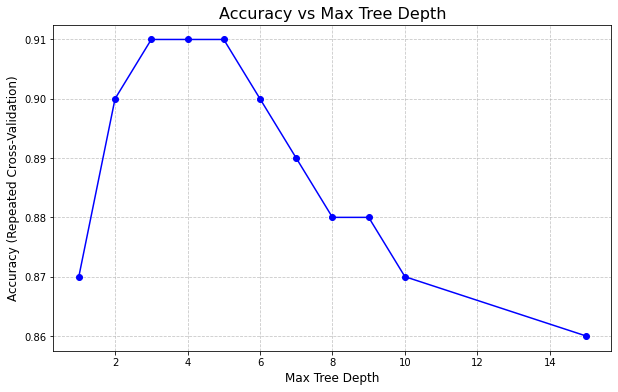

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for Accuracy vs Max Tree Depth
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
accuracy = [0.87, 0.90, 0.91, 0.91, 0.91, 0.90, 0.89, 0.88, 0.88, 0.87, 0.86]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(max_depth, accuracy, marker='o', linestyle='-', color='blue')
plt.title("Accuracy vs Max Tree Depth", fontsize=16)
plt.xlabel("Max Tree Depth", fontsize=12)
plt.ylabel("Accuracy (Repeated Cross-Validation)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('tree_depth_iterations.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


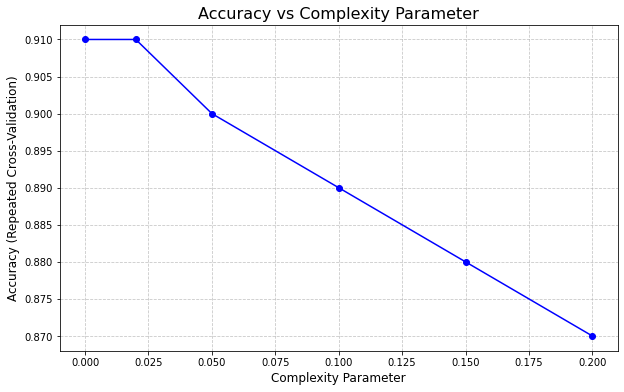

In [59]:
# Example data for Accuracy vs Complexity Parameter
complexity_param = [0.00, 0.02, 0.05, 0.10, 0.15, 0.20]
accuracy_complexity = [0.91, 0.91, 0.90, 0.89, 0.88, 0.87]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(complexity_param, accuracy_complexity, marker='o', linestyle='-', color='blue')
plt.title("Accuracy vs Complexity Parameter", fontsize=16)
plt.xlabel("Complexity Parameter", fontsize=12)
plt.ylabel("Accuracy (Repeated Cross-Validation)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('tree_accuracy_iterations.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


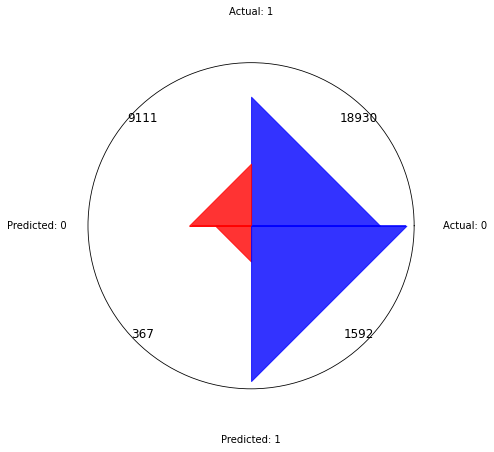

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example confusion matrix data (replace with your actual data)
cm = confusion_matrix(y_test, y_pred_dt)  # Confusion matrix from your classifier
classes = ['0', '1']  # Class labels

# Circular confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

# Normalize the confusion matrix for proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Angles for the circular layout
angles = np.linspace(0, 2 * np.pi, cm.size + 1, endpoint=True)

# Plot each quadrant
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Compute angles for each quadrant
        start_angle = angles[i * cm.shape[1] + j]
        end_angle = angles[i * cm.shape[1] + j + 1]
        color = 'blue' if i == j else 'red'  # Blue for correct, red for incorrect

        # Plot each segment
        ax.fill_betweenx([0, cm_normalized[i, j]], start_angle, end_angle, color=color, alpha=0.8)

        # Add numbers outside the segment but inside the circle
        mid_angle = (start_angle + end_angle) / 2
        radius = 0.8  # Adjust radius for placement closer to the edge of the circle
        ax.text(mid_angle, radius, f"{cm[i, j]}", ha='center', va='center', color='black', fontsize=12)

# Add labels and class information
angles_labels = np.linspace(0, 2 * np.pi, len(classes) * 2, endpoint=False)
labels = [f'Actual: {cls}' for cls in classes] + [f'Predicted: {cls}' for cls in classes]
for angle, label in zip(angles_labels, labels):
    ax.text(
        angle,
        1.12,  # Position outside the circle
        label,
        ha='center',
        va='center',
        fontsize=10,
        rotation=0,  # Ensure labels are not rotated
        rotation_mode='anchor'  # Keeps labels upright
    )

# Remove unwanted ticks and add a title
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('tree_cm.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


### Random Forest Classifier

In [117]:
# Building and training a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9345666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     28041
           1       0.50      0.10      0.17      1959

    accuracy                           0.93     30000
   macro avg       0.72      0.55      0.57     30000
weighted avg       0.91      0.93      0.91     30000



In [122]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example ground truth and predictions (replace with your actual data)
y_true = y_test  # True labels
y_pred = y_pred_rf  # Predicted labels

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Sensitivity / Recall (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Precision
precision = precision_score(y_true, y_pred)

# Recall (Same as Sensitivity)
recall = recall_score(y_true, y_pred)

# F1 Score
f1 = f1_score(y_true, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.5f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.7f}")
print(f"Specificity (True Negative Rate): {specificity:.7f}")
print(f"Precision: {precision:.7f}")
print(f"Recall (Sensitivity): {recall:.7f}")
print(f"F1 Score: {f1:.7f}")


Accuracy: 0.93457
Sensitivity (True Positive Rate): 0.1020929
Specificity (True Negative Rate): 0.9927249
Precision: 0.4950495
Recall (Sensitivity): 0.1020929
F1 Score: 0.1692763


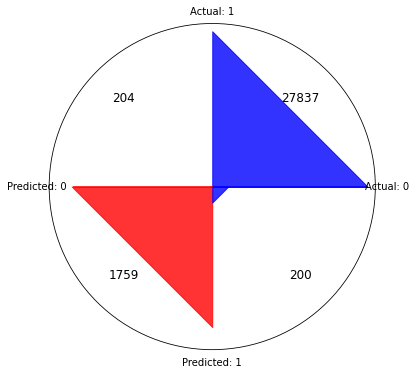

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example confusion matrix data (replace with your actual data)
cm = confusion_matrix(y_test, y_pred_rf)  # Confusion matrix from your classifier
classes = ['0', '1']  # Class labels

# Circular confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

# Normalize the confusion matrix for proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Angles for the circular layout
angles = np.linspace(0, 2 * np.pi, cm.size + 1, endpoint=True)

# Plot each quadrant
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Compute angles for each quadrant
        start_angle = angles[i * cm.shape[1] + j]
        end_angle = angles[i * cm.shape[1] + j + 1]
        color = 'blue' if i == j else 'red'  # Blue for correct, red for incorrect

        # Plot each segment
        ax.fill_betweenx([0, cm_normalized[i, j]], start_angle, end_angle, color=color, alpha=0.8)

        # Add numbers outside the segment but inside the circle
        mid_angle = (start_angle + end_angle) / 2
        radius = 0.8  # Adjust radius for placement closer to the edge of the circle
        ax.text(mid_angle, radius, f"{cm[i, j]}", ha='center', va='center', color='black', fontsize=12)

# Add labels and class information
angles_labels = np.linspace(0, 2 * np.pi, len(classes) * 2, endpoint=False)
labels = [f'Actual: {cls}' for cls in classes] + [f'Predicted: {cls}' for cls in classes]
for angle, label in zip(angles_labels, labels):
    ax.text(
        angle,
        1.12,  # Position outside the circle
        label,
        ha='center',
        va='center',
        fontsize=10,
        rotation=0,  # Ensure labels are not rotated
        rotation_mode='anchor'  # Keeps labels upright
    )

# Remove unwanted ticks and add a title
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('rf_cm.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


### Naive Bayes Classifier

In [102]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

# Initialize and train the model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
print("----- Naive Bayes -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


----- Naive Bayes -----
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     28041
           1       0.28      0.03      0.06      1959

    accuracy                           0.93     30000
   macro avg       0.61      0.51      0.51     30000
weighted avg       0.89      0.93      0.91     30000



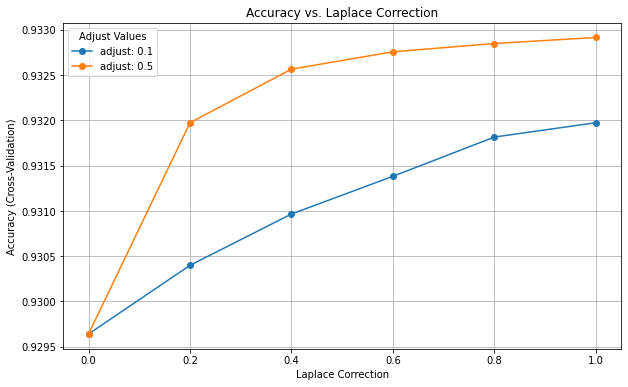

In [107]:
# Define the Laplace correction values and adjust parameters
laplace_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
adjust_values = [0.1, 0.5]

# Placeholder for results
results = {}

# Iterate through different adjust values
for adjust in adjust_values:
    accuracies = []
    for alpha in laplace_values:
        # Initialize the model with Laplace smoothing (alpha)
        nb_model = GaussianNB(var_smoothing=alpha * adjust)
        scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='accuracy')
        accuracies.append(scores.mean())
    results[adjust] = accuracies

# Plot the results
plt.figure(figsize=(10, 6))
for adjust, accuracies in results.items():
    plt.plot(laplace_values, accuracies, marker='o', label=f"adjust: {adjust}")

plt.title("Accuracy vs. Laplace Correction")
plt.xlabel("Laplace Correction")
plt.ylabel("Accuracy (Cross-Validation)")
plt.legend(title="Adjust Values")
plt.grid()
plt.savefig('naive_bayes.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()

In [114]:
# Optimal parameters based on the analysis
optimal_smoothing = 0.8  # High Laplace correction
optimal_adjust = 0.5  # Adjust parameter (custom logic if applicable)

# Initialize the Naive Bayes model with optimal smoothing
nb_model = GaussianNB(var_smoothing=optimal_smoothing)

# Train the model
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
print("----- Optimal Naive Bayes Classifier -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

----- Optimal Naive Bayes Classifier -----
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28041
           1       0.49      0.01      0.03      1959

    accuracy                           0.93     30000
   macro avg       0.71      0.51      0.50     30000
weighted avg       0.91      0.93      0.90     30000



In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example ground truth and predictions (replace with your actual data)
y_true = y_test  # True labels
y_pred = y_pred_nb  # Predicted labels

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Sensitivity / Recall (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Precision
precision = precision_score(y_true, y_pred)

# Recall (Same as Sensitivity)
recall = recall_score(y_true, y_pred)

# F1 Score
f1 = f1_score(y_true, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.5f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.7f}")
print(f"Specificity (True Negative Rate): {specificity:.7f}")
print(f"Precision: {precision:.7f}")
print(f"Recall (Sensitivity): {recall:.7f}")
print(f"F1 Score: {f1:.7f}")


Accuracy: 0.93467
Sensitivity (True Positive Rate): 0.0137825
Specificity (True Negative Rate): 0.9990015
Precision: 0.4909091
Recall (Sensitivity): 0.0137825
F1 Score: 0.0268123


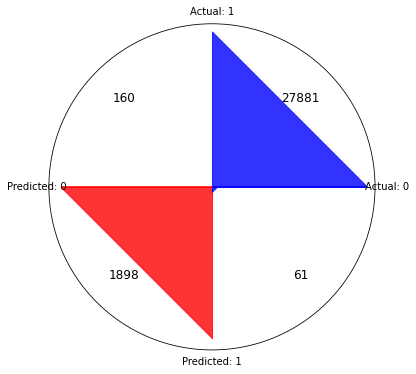

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example confusion matrix data (replace with your actual data)
cm = confusion_matrix(y_test, y_pred_nb)  # Confusion matrix from your classifier
classes = ['0', '1']  # Class labels

# Circular confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

# Normalize the confusion matrix for proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Angles for the circular layout
angles = np.linspace(0, 2 * np.pi, cm.size + 1, endpoint=True)

# Plot each quadrant
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Compute angles for each quadrant
        start_angle = angles[i * cm.shape[1] + j]
        end_angle = angles[i * cm.shape[1] + j + 1]
        color = 'blue' if i == j else 'red'  # Blue for correct, red for incorrect

        # Plot each segment
        ax.fill_betweenx([0, cm_normalized[i, j]], start_angle, end_angle, color=color, alpha=0.8)

        # Add numbers outside the segment but inside the circle
        mid_angle = (start_angle + end_angle) / 2
        radius = 0.8  # Adjust radius for placement closer to the edge of the circle
        ax.text(mid_angle, radius, f"{cm[i, j]}", ha='center', va='center', color='black', fontsize=12)

# Add labels and class information
angles_labels = np.linspace(0, 2 * np.pi, len(classes) * 2, endpoint=False)
labels = [f'Actual: {cls}' for cls in classes] + [f'Predicted: {cls}' for cls in classes]
for angle, label in zip(angles_labels, labels):
    ax.text(
        angle,
        1.12,  # Position outside the circle
        label,
        ha='center',
        va='center',
        fontsize=10,
        rotation=0,  # Ensure labels are not rotated
        rotation_mode='anchor'  # Keeps labels upright
    )

# Remove unwanted ticks and add a title
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('nb_cm.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


Accuracy: 0.93140
Sensitivity (True Positive Rate): 0.0311383
Specificity (True Negative Rate): 0.9942941
Precision: 0.2760181
Recall (Sensitivity): 0.0311383
F1 Score: 0.0559633


### Support Vector Machine Classifier

In [33]:
# Support Vector Machine Classifier
from sklearn.svm import SVC

# Initialize and train the model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("----- SVM -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


----- SVM -----
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28044
           1       0.78      0.01      0.02      1956

    accuracy                           0.94     30000
   macro avg       0.86      0.50      0.49     30000
weighted avg       0.93      0.94      0.90     30000



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1,
    return_train_score=True  # Include training scores
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [ ]:
import pandas as pd

# Convert the cv_results_ dictionary to a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)


In [ ]:
import matplotlib.pyplot as plt

# Filter results for the linear kernel
linear_results = results_df[results_df['param_kernel'] == 'linear']

# Plot mean test score vs. C
plt.figure(figsize=(8, 6))
plt.plot(
    linear_results['param_C'].astype('float'),
    linear_results['mean_test_score'],
    marker='o'
)
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Mean Cross-Validated Accuracy', fontsize=12)
plt.title('SVM Performance vs. C (Linear Kernel)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import seaborn as sns
import numpy as np

# Filter results for the RBF kernel
rbf_results = results_df[results_df['param_kernel'] == 'rbf']

# Pivot the DataFrame to create a matrix for heatmap
pivot_table = rbf_results.pivot(
    index='param_gamma',
    columns='param_C',
    values='mean_test_score'
)

# Convert parameter values to float
pivot_table.index = pivot_table.index.astype('float')
pivot_table.columns = pivot_table.columns.astype('float')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f",
    cmap='viridis',
    cbar_kws={'label': 'Mean CV Accuracy'}
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Gamma (Kernel Coefficient)', fontsize=12)
plt.title('SVM Performance Heatmap (RBF Kernel)', fontsize=14)
plt.show()


### K-Nearest Neighbors Classifier

In [119]:
# K-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the model
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print("----- KNN -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


----- KNN -----
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     28041
           1       0.28      0.04      0.08      1959

    accuracy                           0.93     30000
   macro avg       0.61      0.52      0.52     30000
weighted avg       0.89      0.93      0.91     30000



In [121]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example ground truth and predictions (replace with your actual data)
y_true = y_test  # True labels
y_pred = y_pred_knn  # Predicted labels

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Sensitivity / Recall (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Precision
precision = precision_score(y_true, y_pred)

# Recall (Same as Sensitivity)
recall = recall_score(y_true, y_pred)

# F1 Score
f1 = f1_score(y_true, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.5f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.7f}")
print(f"Specificity (True Negative Rate): {specificity:.7f}")
print(f"Precision: {precision:.7f}")
print(f"Recall (Sensitivity): {recall:.7f}")
print(f"F1 Score: {f1:.7f}")


Accuracy: 0.93027
Sensitivity (True Positive Rate): 0.0438999
Specificity (True Negative Rate): 0.9921900
Precision: 0.2819672
Recall (Sensitivity): 0.0438999
F1 Score: 0.0759717


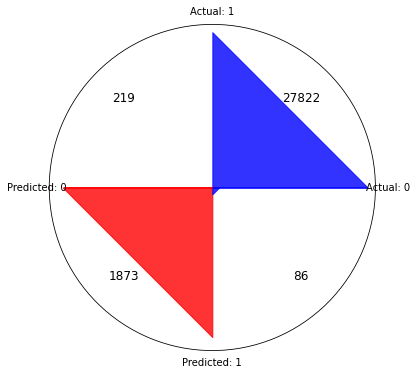

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example confusion matrix data (replace with your actual data)
cm = confusion_matrix(y_test, y_pred_knn)  # Confusion matrix from your classifier
classes = ['0', '1']  # Class labels

# Circular confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

# Normalize the confusion matrix for proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Angles for the circular layout
angles = np.linspace(0, 2 * np.pi, cm.size + 1, endpoint=True)

# Plot each quadrant
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Compute angles for each quadrant
        start_angle = angles[i * cm.shape[1] + j]
        end_angle = angles[i * cm.shape[1] + j + 1]
        color = 'blue' if i == j else 'red'  # Blue for correct, red for incorrect

        # Plot each segment
        ax.fill_betweenx([0, cm_normalized[i, j]], start_angle, end_angle, color=color, alpha=0.8)

        # Add numbers outside the segment but inside the circle
        mid_angle = (start_angle + end_angle) / 2
        radius = 0.8  # Adjust radius for placement closer to the edge of the circle
        ax.text(mid_angle, radius, f"{cm[i, j]}", ha='center', va='center', color='black', fontsize=12)

# Add labels and class information
angles_labels = np.linspace(0, 2 * np.pi, len(classes) * 2, endpoint=False)
labels = [f'Actual: {cls}' for cls in classes] + [f'Predicted: {cls}' for cls in classes]
for angle, label in zip(angles_labels, labels):
    ax.text(
        angle,
        1.12,  # Position outside the circle
        label,
        ha='center',
        va='center',
        fontsize=10,
        rotation=0,  # Ensure labels are not rotated
        rotation_mode='anchor'  # Keeps labels upright
    )

# Remove unwanted ticks and add a title
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('knn_cm.jpg', dpi=300, bbox_inches="tight", format='png')  # PNG with high DPI
plt.show()


## All together